In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import os
from tqdm import tqdm
%matplotlib inline

# Camera Calibration

In [2]:
cal_images = glob.glob('camera_cal/*.jpg')

objpoints = []  # 3D object points
imgpoints = []  # 2D image points
nx = 9
ny = 5
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

for cal_img in tqdm(cal_images):
    img = cv2.imread(cal_img)
    #plt.imshow(img)
    
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)

100%|██████████| 20/20 [00:38<00:00,  2.37s/it]


In [3]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

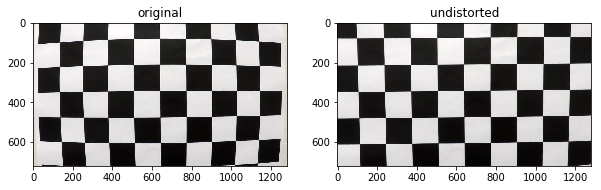

In [4]:
img = cv2.imread(cal_images[0])
dst = cv2.undistort(img, mtx, dist, None, mtx)

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(img[:,:,::-1])
plt.title('original')
plt.subplot(122)
plt.imshow(dst[:,:,::-1])
plt.title('undistorted')

# Undistort Test Images

In [5]:
input_dir = 'test_images/'
output_dir = 'output_images/undistort/'

input_fnames = glob.glob(os.path.join(input_dir, '*.jpg'))

for fname in tqdm(input_fnames):
    img = cv2.imread(fname)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    cv2.imwrite(os.path.join(output_dir, os.path.basename(fname)), dst)

100%|██████████| 8/8 [00:00<00:00, 11.63it/s]


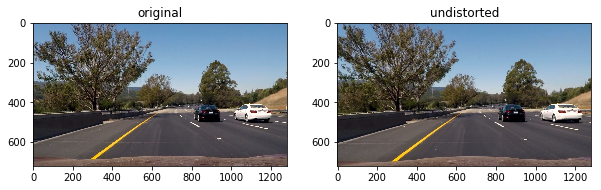

In [6]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(img[:,:,::-1])
plt.title('original')
plt.subplot(122)
plt.imshow(dst[:,:,::-1])
plt.title('undistorted')

# Generate lane pixels

In [62]:
def pipeline(img, sobel_ksize=3, s_thresh=(160, 255), visualize=False):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    h_channel = hsv[:,:,0]
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]

    ch = s_channel
    sx_thresh=(80, 255)
    # Sobel x
    sobelx = cv2.Sobel(ch, cv2.CV_64F, 1, 0, ksize=sobel_ksize) 
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))   
    # Threshold x gradient
    sxbinary1 = np.zeros_like(scaled_sobel)
    sxbinary1[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    ch = l_channel
    sx_thresh=(60, 255)
    sobelx = cv2.Sobel(ch, cv2.CV_64F, 1, 0, ksize=sobel_ksize) 
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel2 = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # Threshold x gradient
    sxbinary2 = np.zeros_like(scaled_sobel)
    sxbinary2[(scaled_sobel2 >= sx_thresh[0]) & (scaled_sobel2 <= sx_thresh[1])] = 1
    
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(sxbinary1 == 1) | (sxbinary2 == 1)] = 1
  
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 255
    
    if visualize:
        color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary))
        plt.figure(figsize=(12,4))
        plt.subplot(121)
        plt.imshow(color_binary)
        plt.title('green: sobelx, blue: s-ch')
        plt.subplot(122)
        plt.imshow(combined_binary, cmap='gray')
        plt.title('combined')
    
    return combined_binary

100%|██████████| 8/8 [00:00<00:00, 10.94it/s]


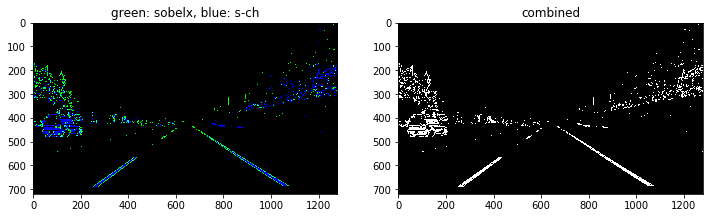

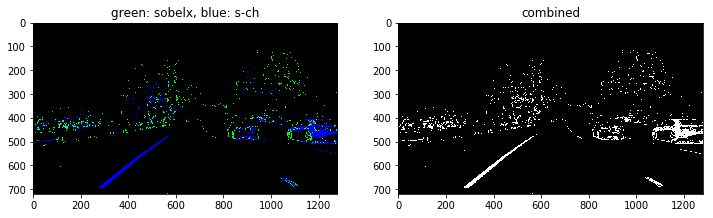

In [63]:
input_dir = 'output_images/undistort/'
output_dir = 'output_images/binary/'
input_fnames = glob.glob(os.path.join(input_dir, '*.jpg'))

for fname in tqdm(input_fnames):
    img = cv2.imread(fname)
    dst = pipeline(img)
    cv2.imwrite(os.path.join(output_dir, os.path.basename(fname)), dst)

result = pipeline(cv2.imread(input_fnames[1]), visualize=True)
result = pipeline(cv2.imread(input_fnames[2]), visualize=True)

# Perspective Transform

In [64]:
imshape = img.shape
pts = np.array([[imshape[1]*0.16, imshape[0]*1.0], [imshape[1]*0.46, imshape[0]*0.63],
                [imshape[1]*0.54, imshape[0]*0.63], [imshape[1]*0.87, imshape[0]*1.0]], dtype=np.int32)

dst = np.array([[imshape[1]*0.2, imshape[0]*0.95], [imshape[1]*0.2, imshape[0]*0.05],
                [imshape[1]*0.8, imshape[0]*0.05], [imshape[1]*0.8, imshape[0]*0.95]], dtype=np.int32)

pts = np.float32(pts)
dst = np.float32(dst)
M = cv2.getPerspectiveTransform(pts, dst)
Minv = cv2.getPerspectiveTransform(dst, pts)

input_dir = 'output_images/undistort/'
output_dir = 'output_images/warped/'
input_fnames = glob.glob(os.path.join(input_dir, '*.jpg'))

for fname in tqdm(input_fnames):    
    img = cv2.imread(fname)
    imshape = img.shape

    roi = np.copy(img)
    _ = cv2.polylines(roi, [np.int32(pts)], True, (0,0,255),3)
    cv2.imwrite(os.path.join(output_dir, os.path.basename(fname.replace('.jpg', '_original.jpg'))), roi)
    
    #plt.imshow(roi[:,:,::-1])
    

    warped = cv2.warpPerspective(img, M, imshape[:-1][::-1], flags=cv2.INTER_LINEAR)    
    warped_roi = np.copy(warped)
    _ = cv2.polylines(warped_roi, [np.int32(dst)], True, (0,0,255),3)
    cv2.imwrite(os.path.join(output_dir, os.path.basename(fname.replace('.jpg', '_warped.jpg'))), warped_roi)
    
    #plt.imshow(warped[:,:,::-1])

100%|██████████| 8/8 [00:00<00:00, 12.63it/s]


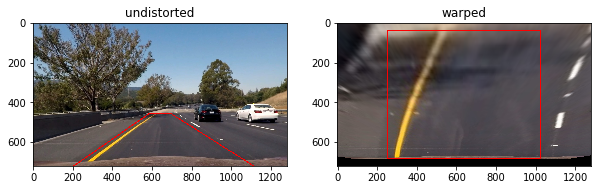

In [65]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(roi[:,:,::-1])
plt.title('undistorted')
plt.subplot(122)
plt.imshow(warped_roi[:,:,::-1])
plt.title('warped')

In [66]:
input_dir = 'output_images/binary/'
output_dir = 'output_images/binary_warped/'
input_fnames = glob.glob(os.path.join(input_dir, '*.jpg'))

for fname in tqdm(input_fnames):    
    img = cv2.imread(fname)
    imshape = img.shape
    warped = cv2.warpPerspective(img, M, imshape[:-1][::-1], flags=cv2.INTER_LINEAR)    
    cv2.imwrite(os.path.join(output_dir, os.path.basename(fname)), warped)
    #plt.imshow(warped[:,:,::-1])

100%|██████████| 8/8 [00:00<00:00, 29.84it/s]


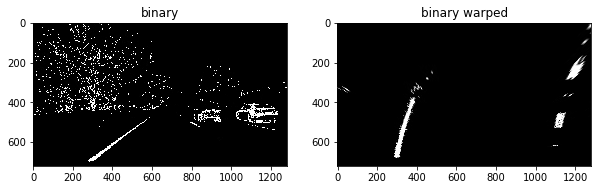

In [67]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(img[:,:,::-1])
plt.title('binary')
plt.subplot(122)
plt.imshow(warped[:,:,::-1])
plt.title('binary warped')

# Find lanes

In [68]:
input_dir = 'output_images/binary_warped/'
output_dir = 'output_images/lane_labeled/'
output_dir2 = 'output_images/lane_labeled_unwarped/'
input_fnames = glob.glob(os.path.join(input_dir, '*.jpg'))

100%|██████████| 8/8 [00:02<00:00,  2.82it/s]


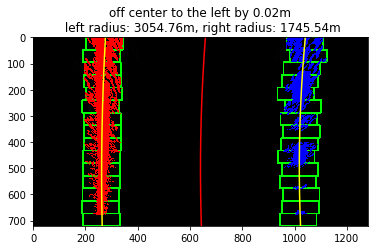

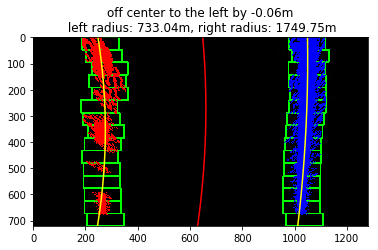

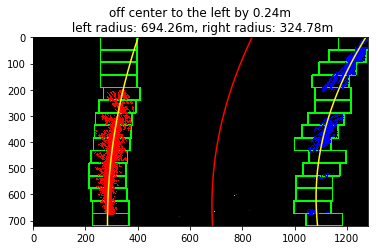

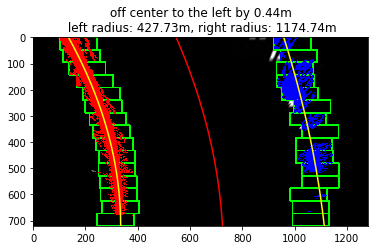

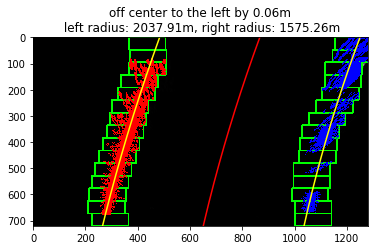

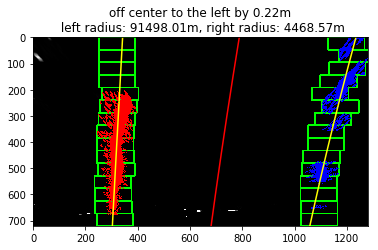

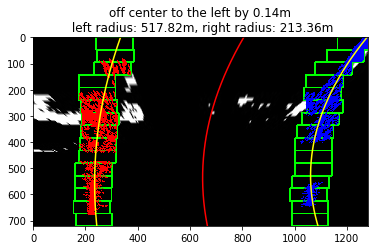

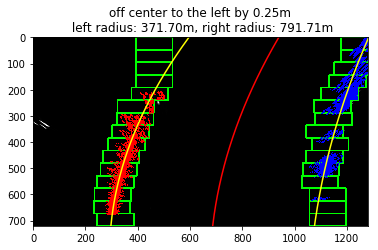

In [72]:
for fname in tqdm(input_fnames):
    img = cv2.imread(fname)
    binary_warped = img
    
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]*.5):,:, 0], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = img
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 15
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 70
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 5) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 5) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.figure()
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    lane_center = (left_fitx + right_fitx )/2
    plt.plot(lane_center, ploty, color='red')
    # plt.xlim(0, 1280)
    # plt.ylim(720, 0)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    off_center_to_the_left = (lane_center[-1] - out_img.shape[1]/2) * xm_per_pix
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    y_eval = ploty.max()
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    
    info_str = 'off center to the left by {:.2f}m\n left radius: {:.2f}m, right radius: {:.2f}m'.format(off_center_to_the_left,
                                                                                           left_curverad, 
                                                                                            right_curverad)
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.title(info_str)
    plt.savefig(os.path.join(output_dir, os.path.basename(fname)))
    #plt.close()
    
    # Create an image to draw the lines on
    color_warp = np.zeros_like(img).astype(np.uint8)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image

    undistort = cv2.imread(os.path.join('output_images/undistort/', os.path.basename(fname)))
    result = cv2.addWeighted(undistort, 1, newwarp, 0.3, 0)
    cv2.imwrite(os.path.join(output_dir2, os.path.basename(fname)), result)

In [73]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped[:,:,0].nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

(720, 0)

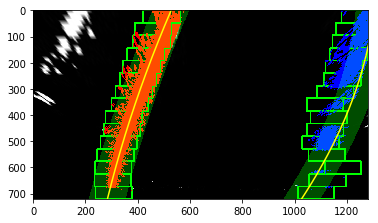

In [16]:
# Create an image to draw on and an image to show the selection window
out_img = img
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [17]:
(binary_warped[:,:,0])

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)